In [1]:
import numpy as np
import matplotlib.pylab as plt

In [2]:
np.set_printoptions(precision=4, suppress=True)

In [3]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))    

In [4]:
def sigmoid_grad(x):
    return (1.0 - sigmoid(x)) * sigmoid(x)

In [5]:
def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T 

    x = x - np.max(x) # 오버플로 대책
    return np.exp(x) / np.sum(np.exp(x))

In [6]:
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    # 훈련 데이터가 One-hot 벡터라면 정답 레이블의 인덱스로 반환
    if t.size == y.size:
        t = t.argmax(axis=1)
             
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

In [7]:
class TwoLayerNet:
    """
      A two-layer fully-connected neural network. The net has an input dimension of
      N, a hidden layer dimension of H, and performs classification over C classes.
    """

    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        """
        가중치 초기화
        Initialize the model. Weights are initialized to small random values and
        biases are initialized to zero. Weights and biases are stored in the
        variable self.params, which is a dictionary with the following keys:
        W1: First layer weights; has shape (D, H)
        b1: First layer biases; has shape (H,)
        W2: Second layer weights; has shape (H, C)
        b2: Second layer biases; has shape (C,)
        Inputs:
        - input_size: The dimension D of the input data.
        - hidden_size: The number of neurons H in the hidden layer.
        - output_size: The number of classes C.
        """
        
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

    def predict(self, x):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
    
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        return y
        
    # x : 입력 데이터, t : 정답 레이블
    def loss(self, x, t):
        y = self.predict(x)
        
        return cross_entropy_error(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
        
    # x : 입력 데이터, t : 정답 레이블
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        
        return grads
        
    def gradient(self, x, t):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
        grads = {}
        
        batch_num = x.shape[0]
        
        # forward
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        # backward
        dy = (y - t) / batch_num # error or loss
        grads['W2'] = np.dot(z1.T, dy)
        grads['b2'] = np.sum(dy, axis=0)
        
        da1 = np.dot(dy, W2.T)
        dz1 = sigmoid_grad(a1) * da1
        grads['W1'] = np.dot(x.T, dz1)
        grads['b1'] = np.sum(dz1, axis=0)

        return grads

In [8]:
network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)


In [9]:
from dataset.mnist import load_mnist
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

* 형상 출력해보기

In [10]:
x_train.shape, t_train.shape, x_test.shape, t_test.shape

((60000, 784), (60000, 10), (10000, 784), (10000, 10))

### 학습하기

* Hyperparameters

In [11]:
iters_num = 10000  # 반복 횟수를 적절히 설정한다.
train_size = x_train.shape[0]
batch_size = 100   # 미니배치 크기
learning_rate = 0.1

In [12]:
train_loss_list = []
train_acc_list = []
test_acc_list = []

* Train the network !

In [13]:
# 1에폭당 반복 수
iter_per_epoch = max(train_size // batch_size, 1)
print('iter_per_epoch = {}//{}={}'.format(train_size, batch_size,iter_per_epoch))

iter_per_epoch = 60000//100=600


In [14]:
for key in ('W1', 'b1', 'W2', 'b2'):
    print(key)

W1
b1
W2
b2


In [15]:
print('epoch\tloss\tacc_trn\tacc_test')
print('---------------------------------')
for i in range(iters_num):
    # 미니배치 획득
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 기울기 계산
    #grad = network.numerical_gradient(x_batch, t_batch)
    grad = network.gradient(x_batch, t_batch)
    
    
    # 매개변수 갱신
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
    
    # 학습 경과 기록
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    # 1 에폭당 정확도 계산
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        
        print('{}\t{:.3f}\t{:.3f}\t{:.3f}'.format(i//iter_per_epoch, loss, train_acc, test_acc))
        

epoch	loss	acc_trn	acc_test
---------------------------------
0	2.292	0.102	0.101
1	0.920	0.801	0.804
2	0.485	0.878	0.880
3	0.424	0.899	0.900
4	0.229	0.907	0.911
5	0.379	0.915	0.918
6	0.384	0.919	0.923
7	0.212	0.924	0.926
8	0.193	0.928	0.930
9	0.157	0.931	0.934
10	0.191	0.934	0.937
11	0.327	0.936	0.937
12	0.294	0.940	0.939
13	0.273	0.941	0.941
14	0.198	0.943	0.943
15	0.120	0.945	0.943
16	0.307	0.947	0.945


### 결과 그려보기 및 분석

Text(0, 0.5, 'loss')

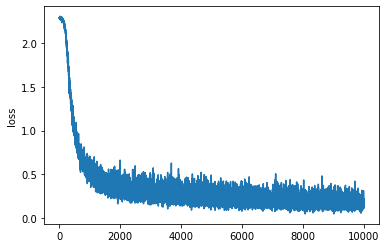

In [16]:
plt.plot(train_loss_list)
plt.ylabel('loss')

* Train accuracy

In [17]:
train_acc = network.accuracy(x_train, t_train)
print(train_acc)

0.9489166666666666


* Test accuracy

In [18]:
test_acc = network.accuracy(x_test, t_test)
print(test_acc)

0.9461


* 하나만 테스트해보기
: 그림 그리는 과정은 03_NeuralNetwork/01_3_NN_MNIST_Exploration.ipynb 을 참고해보세요

In [19]:
idx_to_test = 550 #0~9999 바꾸어서 해보세요
x1 = x_test[idx_to_test]
t1 = t_test[idx_to_test]

In [20]:
x1.shape, t1.shape

((784,), (10,))

In [21]:
title = '#{} {}'.format(np.argmax(t1), t1)
print(title)

#7 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


In [22]:
img = x1.reshape((28,28))

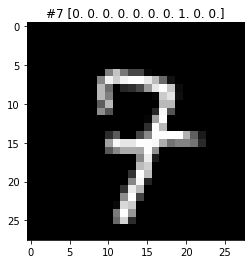

In [23]:
#plt.plot(img)
plt.imshow(img, cmap='gray')
plt.title(title)
plt.show()

In [24]:
y1 = network.predict(x1)

In [25]:
print(y1)

[0.     0.0002 0.0028 0.0209 0.004  0.001  0.     0.6492 0.0005 0.3215]


In [26]:
print(t1) # 정답
print(y1) # 학습된 neural network 가 구한 값. 

[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
[0.     0.0002 0.0028 0.0209 0.004  0.001  0.     0.6492 0.0005 0.3215]


In [27]:
for i in range(10):
    print('#{}\t{}\t{:.3f}'.format(i, t1[i], y1[i]))

#0	0.0	0.000
#1	0.0	0.000
#2	0.0	0.003
#3	0.0	0.021
#4	0.0	0.004
#5	0.0	0.001
#6	0.0	0.000
#7	1.0	0.649
#8	0.0	0.001
#9	0.0	0.321


### TODO

* idx_to_test 를 바꾸어 가며 테스트해보고 결과값 논의해보기 (3개 이상)
```
예를들면 네트워크가 약간이라도 확률을 만들어내는 숫자 분석을 해볼수 있음. 
: 7과 1이 비슷하기에 정답은 7이지만 1에도 약간의 확률값이 생겼다.
```
* Training 이 되기 전에는 어떻게 예측을 하는지 해보기

### References

* Stanford CS231n, Two-layer network <br>
https://cs231n.github.io/
https://github.com/yunjey/cs231n/blob/master/assignment1/cs231n/classifiers/neural_net.py

* 주교재 <br /> https://github.com/WegraLee/deep-learning-from-scratch/blob/master/ch04/train_neuralnet.py